In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as  pm
import pickle
import pytensor.tensor as pt

print(f"Running on PyMC v{pm.__version__}")

/Users/jaeminiman/anaconda3/envs/pytorch/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Running on PyMC v5.6.1


In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

#### 전처리 된 데이터 불러오기

In [7]:
mydict = pd.read_pickle('./data/final_data.pkl')

#### numpy array 형태로 변환

In [4]:
home_X = None
away_X = None
home_y = None
away_y = None

stop = 0

for i in mydict.keys():
    t_game_df, t_home_df, t_away_df = mydict[i]
    
    home_score = t_game_df['home_score']
    away_score = t_game_df['away_score']

    home_elo = t_game_df['home elo']
    away_elo = t_game_df['away elo']

    home_event = t_home_df.values
    away_event = t_away_df.values

    home_event = np.concatenate([home_event, (home_elo-away_elo)*np.ones((20,1))/100, (home_event[:,2] - away_event[:,2]).reshape((20, 1))], axis=1)
    away_event = np.concatenate([away_event, (away_elo-home_elo)*np.ones((20,1))/100, (away_event[:,2] - home_event[:,2]).reshape((20, 1))], axis=1)

    home_output = home_score - home_event[:,2]
    away_output = away_score - away_event[:,2]

    if stop == 0:
        home_y = home_output.reshape(-1,1)
        away_y = away_output.reshape(-1,1)

        home_X = home_event.reshape(20, 1, -1)
        away_X = home_event.reshape(20, 1, -1)

    else :
        home_y = np.concatenate([home_y, home_output.reshape(-1,1)], axis=1)
        away_y = np.concatenate([away_y, away_output.reshape(-1,1)], axis=1)
        
        home_X = np.concatenate([home_X, home_event.reshape(20,1,-1)], axis=1)
        away_X = np.concatenate([away_X, away_event.reshape(20,1,-1)], axis=1)  

    stop += 1

In [5]:
train_data = {'X' : {'home':home_X, 'away':away_X}, 'y' : {'home':home_y, 'away':away_y}}

In [6]:
#with open('./data/train_data.pkl', 'wb') as f:    # james.p 파일을 바이너리 쓰기 모드(wb)로 열기
#    pickle.dump(train_data, f)

#### Bayesian Poisson Model

In [306]:
bayesian_poisson_model = pm.Model()

with bayesian_poisson_model:
    
    alpha = []
    alpha.append(pm.Normal("alpha_1", mu=0, sigma=2, shape=9))
    beta = pm.Normal("beta", sigma = 2)
    hw = pm.HalfNormal("home_ad", sigma=2)

    for i in np.arange(2, 20):
        alpha.append(pm.Normal("alpha_{}".format(i), mu=alpha[-1], sigma=2))

    home_theta = []
    away_theta = []
    for i in np.arange(1, 20):
        home_theta.append((1-(i/20)) * pt.exp(pt.dot(home_X[i-1,:,:], alpha[i-1]) + beta + hw))
        away_theta.append((1-(i/20)) * pt.exp(pt.dot(away_X[i-1,:,:], alpha[i-1]) + beta))
    
    Y_h_ob = []
    for i in np.arange(1, 20):
        Y_h_ob.append(pm.Poisson("Y_h_obs_{}".format(i), home_theta[i-1], observed=home_y[i-1,:]))
        Y_h_ob.append(pm.Poisson("Y_a_obs_{}".format(i), away_theta[i-1], observed=away_y[i-1,:]))



#### 모델의 Graphical 구조

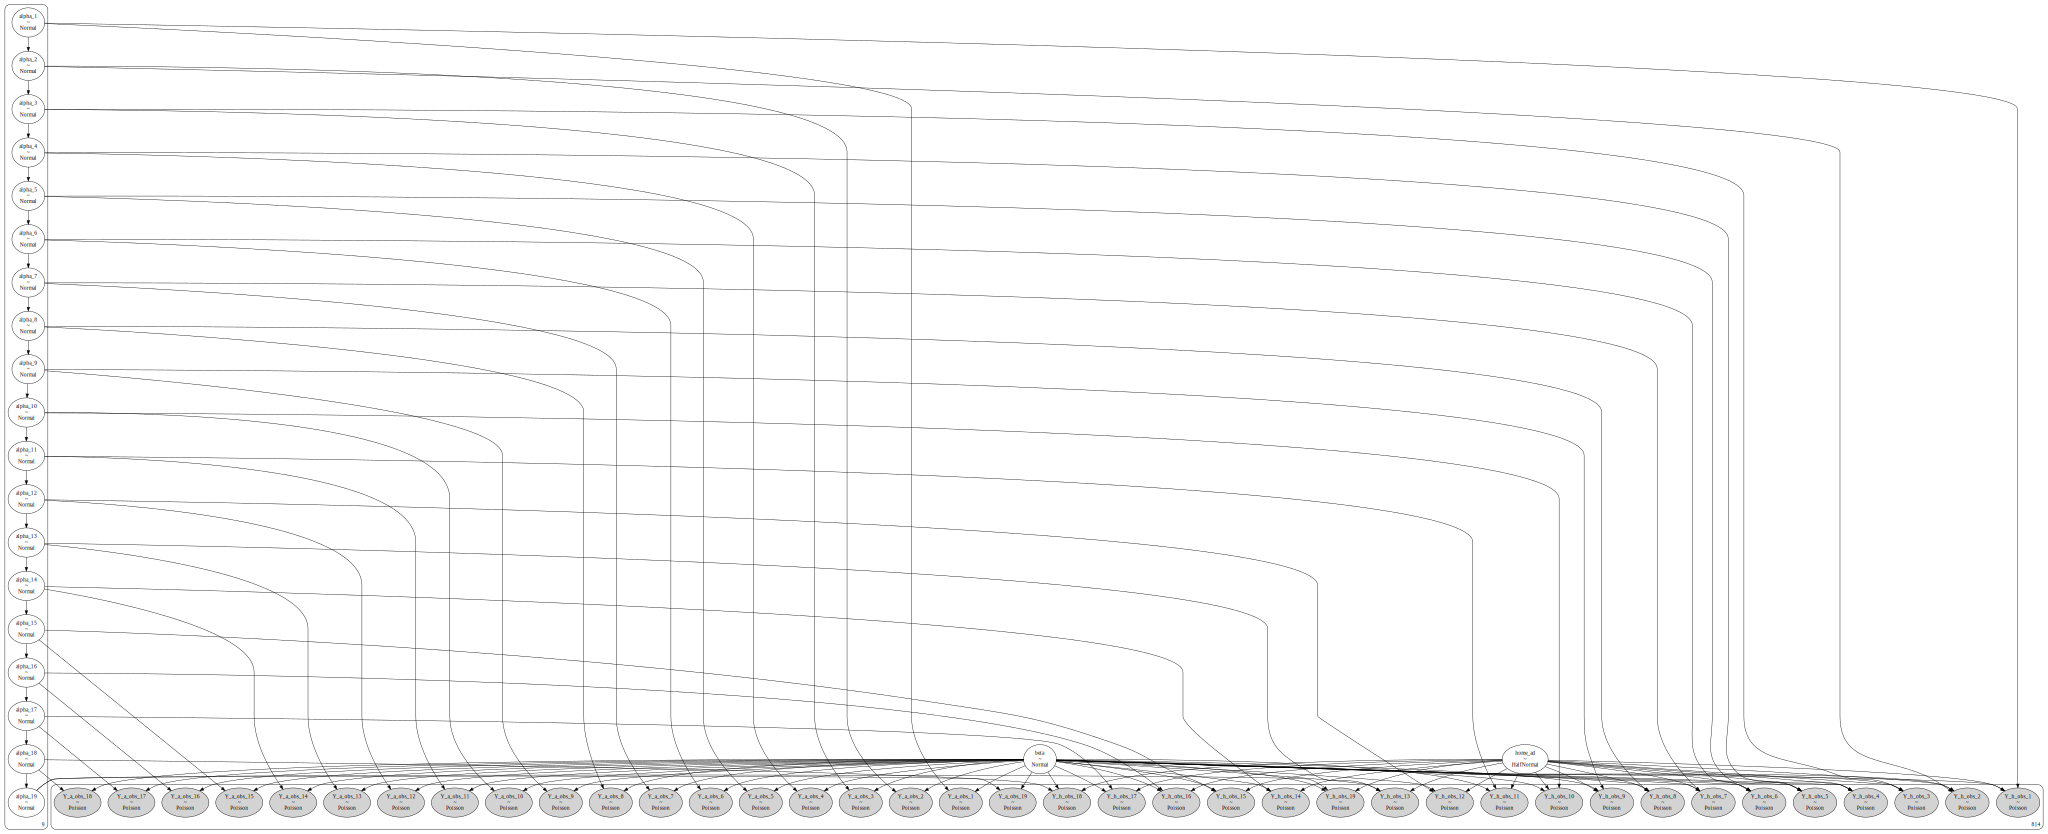

In [307]:
pm.model_to_graphviz(bayesian_poisson_model)

#### ADVI 로 Fitting

In [308]:
with bayesian_poisson_model:
    fit_output = pm.fit()

Finished [100%]: Average Loss = 49,135


In [309]:
approx_sample = fit_output.sample(2000)

#### posterior 분포

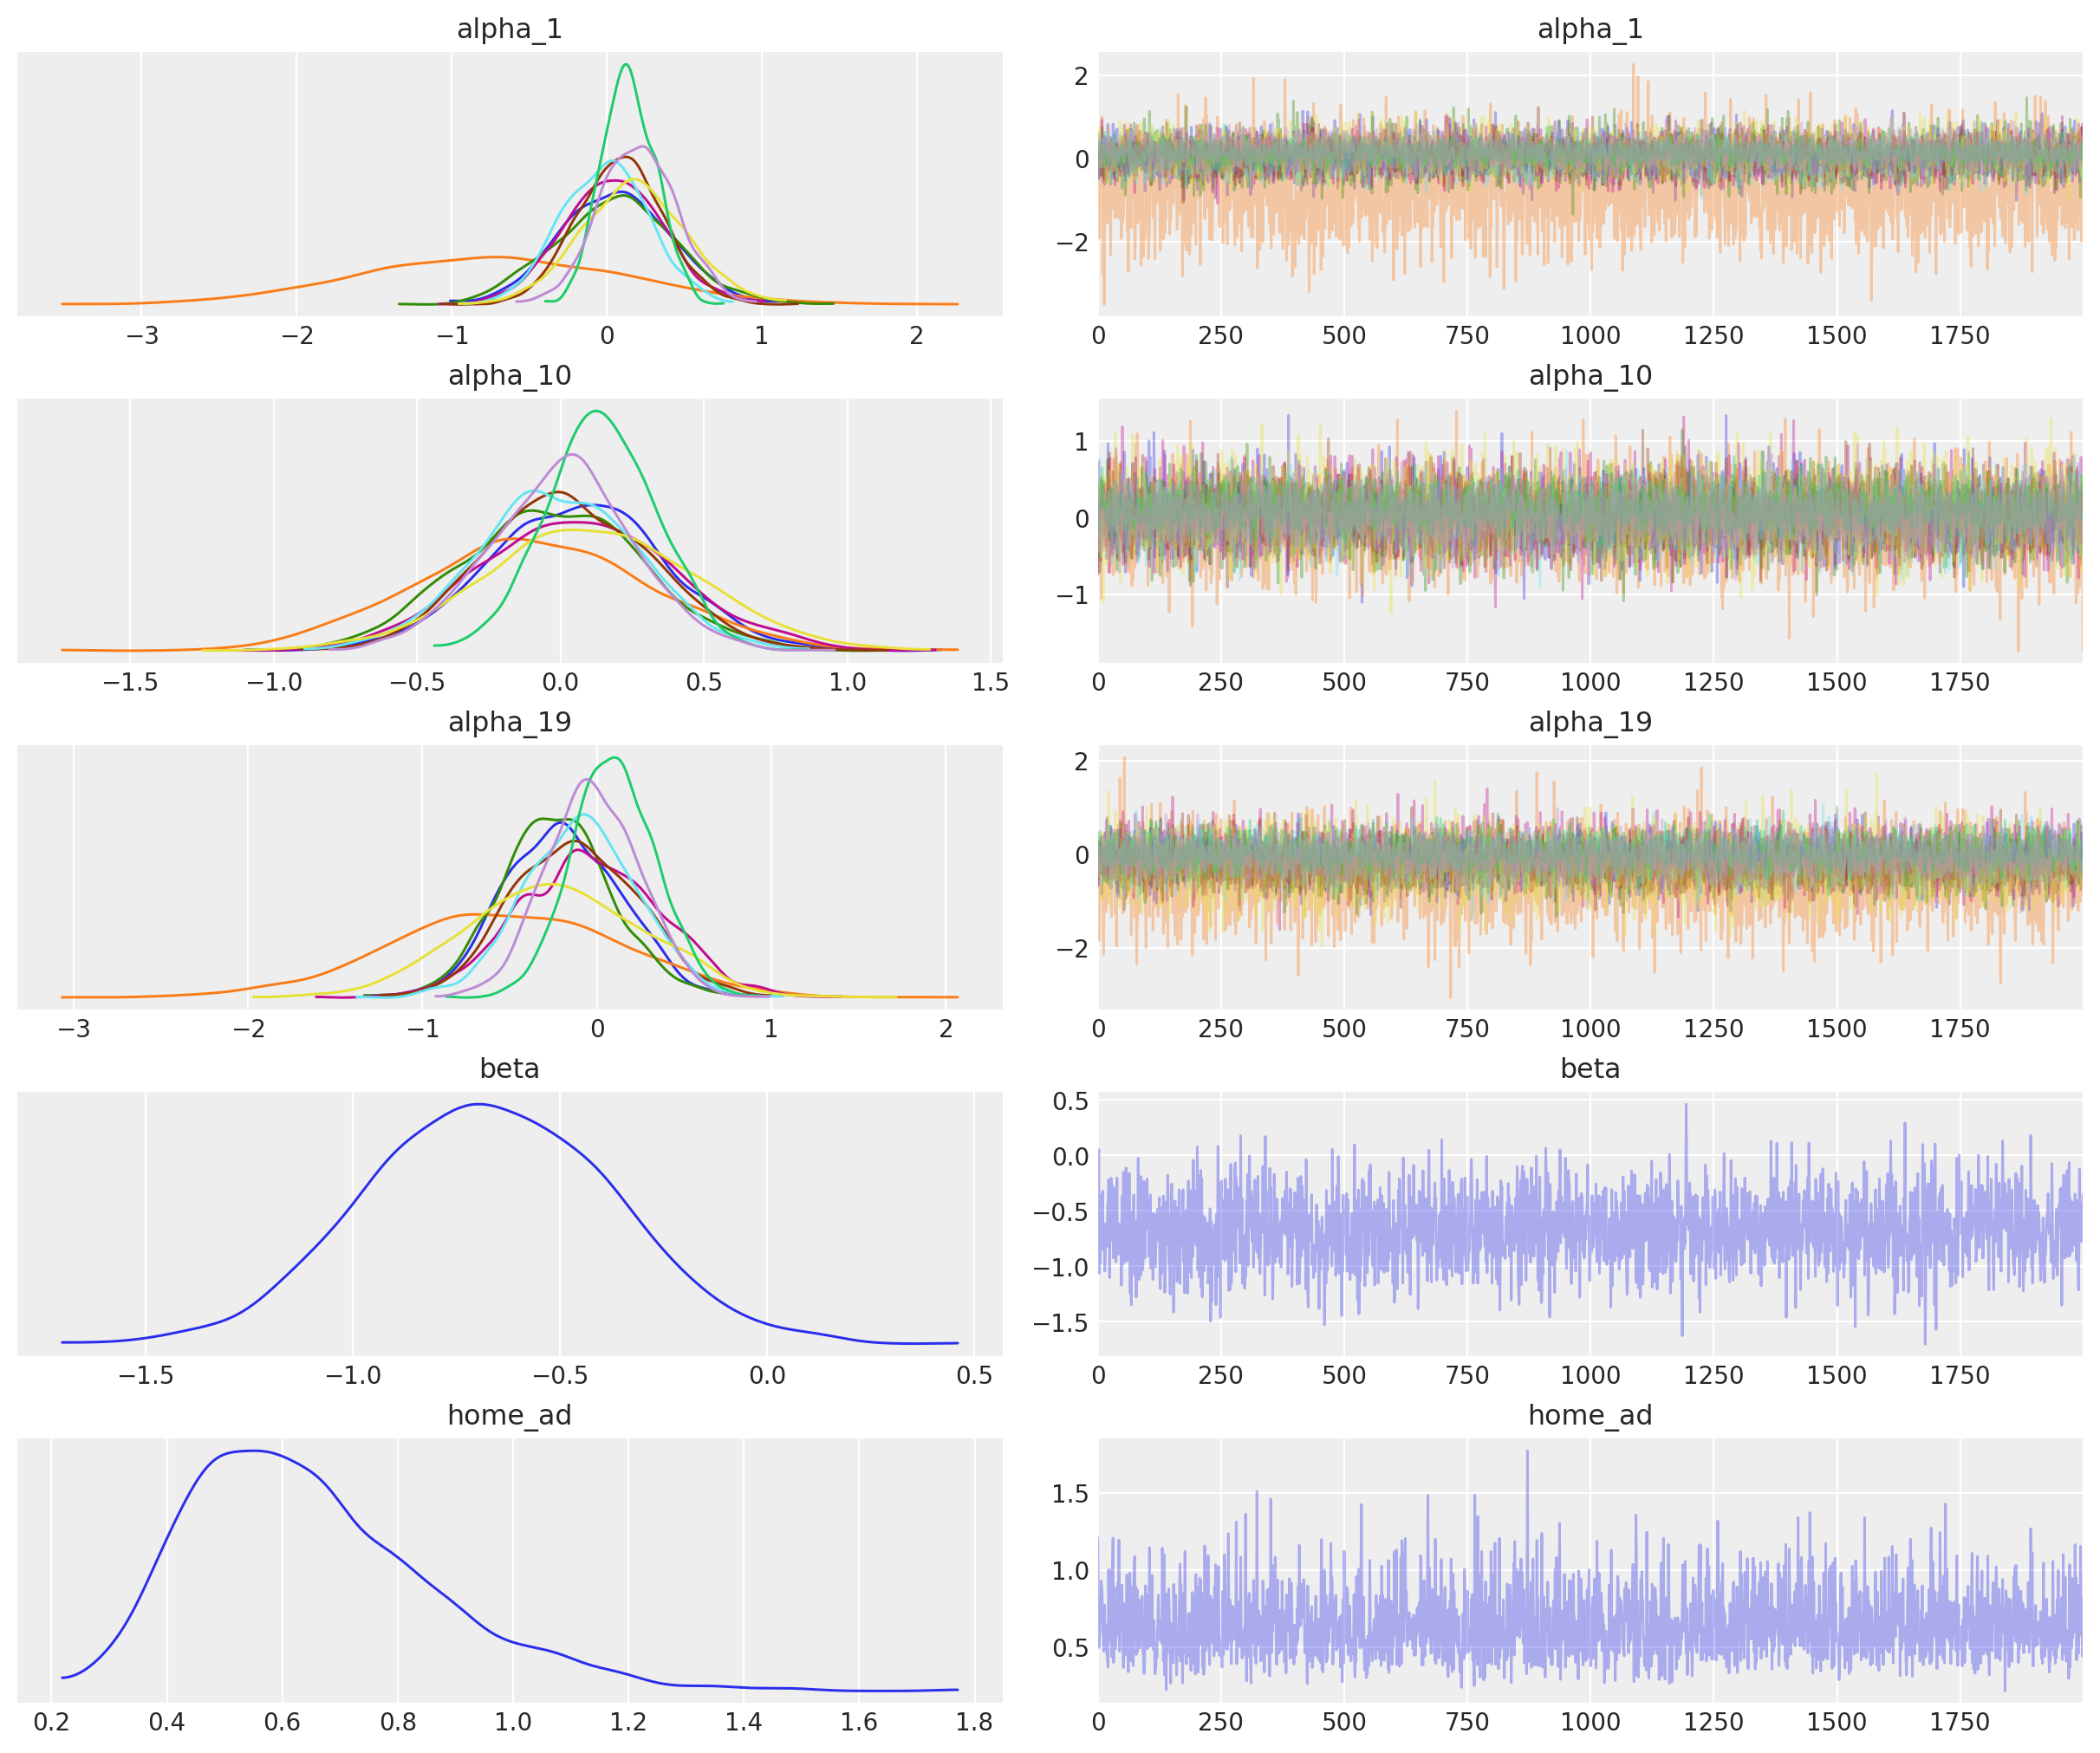

In [310]:
az.plot_trace(approx_sample, var_names=['alpha_1', 'alpha_10', 'alpha_19', 'beta', 'home_ad']);

#### Game-state 별 alpha 값


- '0': 'Yellow Card',
- '1': 'Red Card',
- '2': 'Goal',
- '3': 'Corner',
- '4': 'Foul Committed',
- '5': 'Shot',
- '6': 'Pass Offside',
- '7': 'elo diff',
- '8': 'goal diff'

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

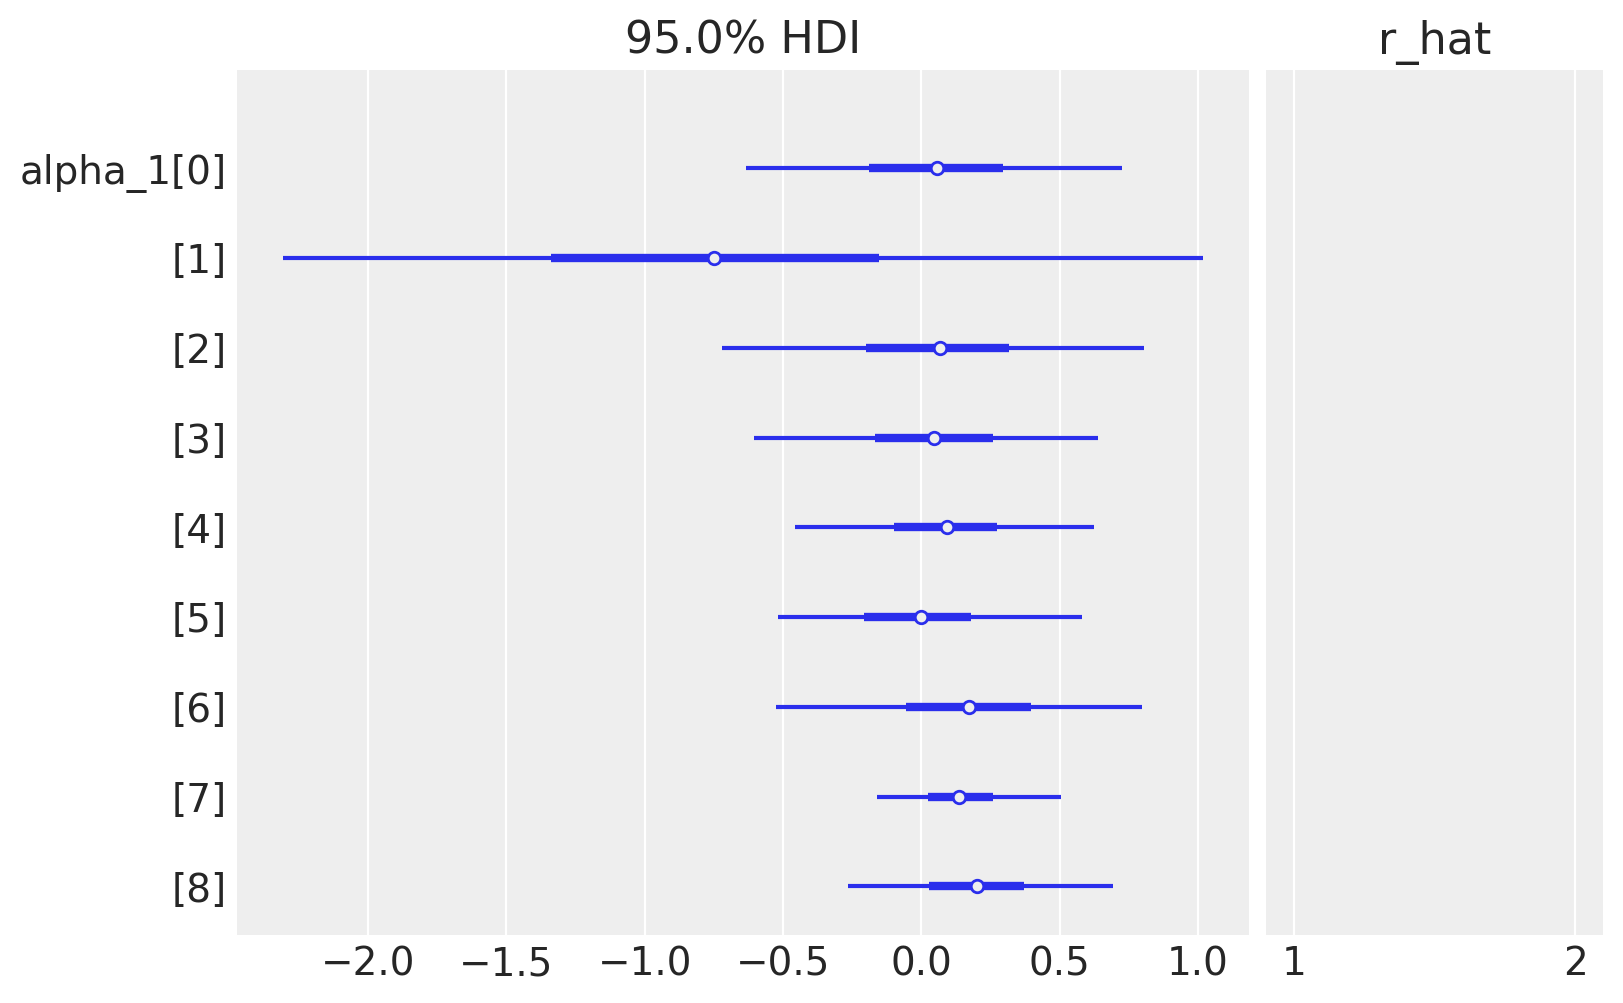

In [316]:
az.plot_forest(approx_sample, var_names=['alpha_1'], combined=True, hdi_prob=0.95, r_hat=True)

In [315]:
approx_sample.posterior.alpha_1.data.mean(axis=1)

array([[ 0.05449182, -0.74405619,  0.0575866 ,  0.04227324,  0.08859711,
        -0.01209409,  0.1733476 ,  0.1419903 ,  0.19926341]])

In [282]:
with open('./results/sampling_results.pkl', 'wb') as f:    # james.p 파일을 바이너리 쓰기 모드(wb)로 열기
    pickle.dump(approx_sample, f)

In [283]:
#approx_sample = pd.read_pickle('./results/sampling_results.pkl')